In [1]:
import numpy as np
import gzip
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
# 模型模块
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, activation='relu'):
        # 初始化权重和偏置
        self.params = {
            'W1': np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size),
            'b1': np.zeros((1, hidden_size)),
            'W2': np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size),
            'b2': np.zeros((1, output_size))
        }
        if activation == 'relu':
            self.activation_function = relu
            self.activation_derivative = relu_derivative

    # 向前传播，激活函数默认设置为relu
    def forward(self, X):
        Z1 = np.dot(X, self.params['W1']) + self.params['b1']
        A1 = self.activation_function(Z1)
        Z2 = np.dot(A1, self.params['W2']) + self.params['b2']
        A2 = softmax(Z2)
        self.cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
        return A2

    # 通过反向传播计算给定损失的梯度
    def backward(self, X, y):
        m = y.shape[0]
        output_error = self.cache['A2'] - y
        dW2 = np.dot(self.cache['A1'].T, output_error) / m
        db2 = np.sum(output_error, axis=0, keepdims=True) / m
        hidden_error = np.dot(output_error, self.params['W2'].T) * self.activation_derivative(self.cache['Z1'])
        dW1 = np.dot(X.T, hidden_error) / m
        db1 = np.sum(hidden_error, axis=0, keepdims=True) / m
        return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}

    # 更新
    def update_params(self, grads, learning_rate, lambda_reg=0.001):
        for key in ['W1', 'W2']:
            self.params[key] -= learning_rate * (grads[key] + lambda_reg * self.params[key])
        for key in ['b1', 'b2']:
            self.params[key] -= learning_rate * grads[key]

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# 交叉熵损失
def cross_entropy(predictions, labels):
    return -np.sum(labels * np.log(predictions + 1e-10)) / predictions.shape[0]

In [3]:
# 训练
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, lambda_reg=0.001, lr_decay=0.95):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'grad_norms': []}
    best_val_acc = 0
    best_params = {}
    # SGD优化器
    for epoch in range(epochs):
        current_lr = learning_rate * (lr_decay ** epoch)
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]
        epoch_grads = []
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]
            outputs = model.forward(X_batch)
            loss = cross_entropy(outputs, y_batch)
            grads = model.backward(X_batch, y_batch)
            model.update_params(grads, current_lr, lambda_reg)
            grad_norm = np.linalg.norm(np.concatenate([grad.flatten() for grad in grads.values()]))
            epoch_grads.append(grad_norm)
        history['grad_norms'].append(np.mean(epoch_grads))
        train_loss, train_acc = evaluate(model, X_train, y_train)
        val_loss, val_acc = evaluate(model, X_val, y_val)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
        
        # 根据验证集指标自动保存最优的模型权重
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {k: v.copy() for k, v in model.params.items()}
    model.params = best_params
    return history

def evaluate(model, X, y, batch_size=1024):
    # 评估模型性能
    total_loss = 0
    correct_preds = 0
    total_samples = X.shape[0]
    for start_idx in range(0, total_samples, batch_size):
        end_idx = min(start_idx + batch_size, total_samples)
        X_batch = X[start_idx:end_idx]
        y_batch = y[start_idx:end_idx]
        outputs = model.forward(X_batch)
        total_loss += cross_entropy(outputs, y_batch) * (end_idx - start_idx)
        predictions = np.argmax(outputs, axis=1)
        labels = np.argmax(y_batch, axis=1)
        correct_preds += np.sum(predictions == labels)
    average_loss = total_loss / total_samples
    accuracy = correct_preds / total_samples
    return average_loss, accuracy

In [4]:
def plot_h(train):
    plt.plot(train['train_loss'], label='Training Loss')
    plt.plot(train['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(train['train_acc'])
    plt.plot(train['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.show()

In [5]:
# 网格搜索
def grid_search(X_train, y_train, X_val, y_val, learning_rates, hidden_sizes, lambdas, input_size, output_size, batch_size, epochs=50):
    
    # 调节学习率、隐藏层大小、正则化强度
    for lr in learning_rates:
        for hidden_size in hidden_sizes:
            for lambda_reg in lambdas:
                model = NeuralNetwork(input_size, hidden_size, output_size)
                history = train(model, X_train, y_train, X_val, y_val, epochs, batch_size, lr, lambda_reg)
                current_val_acc = max(history['val_acc'])

                # 在验证集上评价模型并保存最佳模型
                if current_val_acc > best_overall_val_acc:
                    best_overall_val_acc = current_val_acc
                    best_overall_params = model.params.copy()
                    best_lr = lr
                    best_hidden_size = hidden_size
                    best_lambda_reg = lambda_reg

    return best_overall_params

Epoch 1/50, Train Loss: 0.6674, Validation Loss: 0.6807, Validation Accuracy: 0.7665
Epoch 2/50, Train Loss: 0.5720, Validation Loss: 0.5871, Validation Accuracy: 0.7970
Epoch 3/50, Train Loss: 0.5322, Validation Loss: 0.5464, Validation Accuracy: 0.8122
Epoch 4/50, Train Loss: 0.5029, Validation Loss: 0.5166, Validation Accuracy: 0.8215
Epoch 5/50, Train Loss: 0.4868, Validation Loss: 0.5007, Validation Accuracy: 0.8257
Epoch 6/50, Train Loss: 0.4728, Validation Loss: 0.4866, Validation Accuracy: 0.8320
Epoch 7/50, Train Loss: 0.4673, Validation Loss: 0.4820, Validation Accuracy: 0.8315
Epoch 8/50, Train Loss: 0.4545, Validation Loss: 0.4687, Validation Accuracy: 0.8358
Epoch 9/50, Train Loss: 0.4492, Validation Loss: 0.4632, Validation Accuracy: 0.8363
Epoch 10/50, Train Loss: 0.4419, Validation Loss: 0.4566, Validation Accuracy: 0.8412
Epoch 11/50, Train Loss: 0.4413, Validation Loss: 0.4552, Validation Accuracy: 0.8425
Epoch 12/50, Train Loss: 0.4346, Validation Loss: 0.4488, Valid

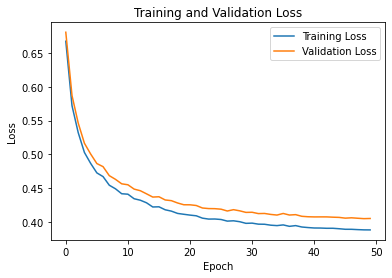

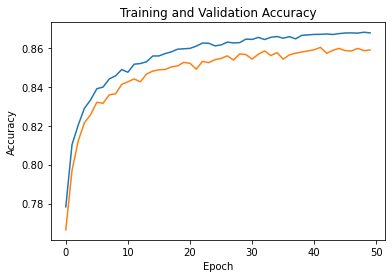

LR: 0.01, Hidden: 50, Lambda: 0.001, Best Val Acc: 0.8601666666666666
Epoch 1/50, Train Loss: 0.7075, Validation Loss: 0.7212, Validation Accuracy: 0.7710
Epoch 2/50, Train Loss: 0.5979, Validation Loss: 0.6133, Validation Accuracy: 0.8012
Epoch 3/50, Train Loss: 0.5583, Validation Loss: 0.5711, Validation Accuracy: 0.8115
Epoch 4/50, Train Loss: 0.5353, Validation Loss: 0.5477, Validation Accuracy: 0.8207
Epoch 5/50, Train Loss: 0.5197, Validation Loss: 0.5320, Validation Accuracy: 0.8270
Epoch 6/50, Train Loss: 0.5114, Validation Loss: 0.5242, Validation Accuracy: 0.8262
Epoch 7/50, Train Loss: 0.5055, Validation Loss: 0.5183, Validation Accuracy: 0.8277
Epoch 8/50, Train Loss: 0.5054, Validation Loss: 0.5179, Validation Accuracy: 0.8247
Epoch 9/50, Train Loss: 0.4960, Validation Loss: 0.5073, Validation Accuracy: 0.8325
Epoch 10/50, Train Loss: 0.4943, Validation Loss: 0.5060, Validation Accuracy: 0.8298
Epoch 11/50, Train Loss: 0.4902, Validation Loss: 0.5019, Validation Accuracy: 

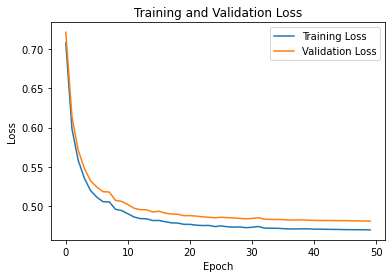

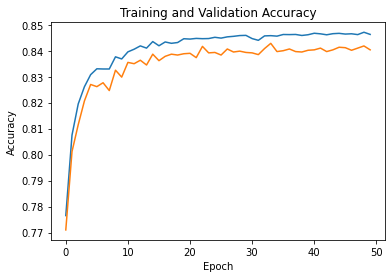

LR: 0.01, Hidden: 50, Lambda: 0.01, Best Val Acc: 0.8428333333333333
Epoch 1/50, Train Loss: 0.9198, Validation Loss: 0.9335, Validation Accuracy: 0.7190
Epoch 2/50, Train Loss: 0.9168, Validation Loss: 0.9281, Validation Accuracy: 0.7157
Epoch 3/50, Train Loss: 0.9107, Validation Loss: 0.9202, Validation Accuracy: 0.7417
Epoch 4/50, Train Loss: 0.9076, Validation Loss: 0.9175, Validation Accuracy: 0.7342
Epoch 5/50, Train Loss: 0.9016, Validation Loss: 0.9113, Validation Accuracy: 0.7343
Epoch 6/50, Train Loss: 0.8989, Validation Loss: 0.9063, Validation Accuracy: 0.7487
Epoch 7/50, Train Loss: 0.8973, Validation Loss: 0.9059, Validation Accuracy: 0.7452
Epoch 8/50, Train Loss: 0.8928, Validation Loss: 0.9010, Validation Accuracy: 0.7427
Epoch 9/50, Train Loss: 0.8942, Validation Loss: 0.9010, Validation Accuracy: 0.7322
Epoch 10/50, Train Loss: 0.8902, Validation Loss: 0.8973, Validation Accuracy: 0.7410
Epoch 11/50, Train Loss: 0.8887, Validation Loss: 0.8962, Validation Accuracy: 0

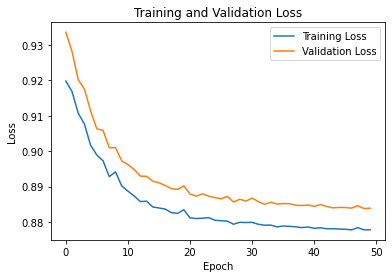

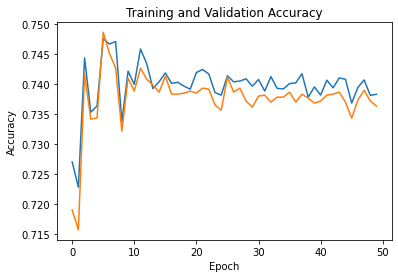

LR: 0.01, Hidden: 50, Lambda: 0.1, Best Val Acc: 0.7486666666666667
Epoch 1/50, Train Loss: 0.6568, Validation Loss: 0.6687, Validation Accuracy: 0.7778
Epoch 2/50, Train Loss: 0.5593, Validation Loss: 0.5716, Validation Accuracy: 0.8073
Epoch 3/50, Train Loss: 0.5195, Validation Loss: 0.5322, Validation Accuracy: 0.8168
Epoch 4/50, Train Loss: 0.5005, Validation Loss: 0.5134, Validation Accuracy: 0.8223
Epoch 5/50, Train Loss: 0.4785, Validation Loss: 0.4911, Validation Accuracy: 0.8262
Epoch 6/50, Train Loss: 0.4660, Validation Loss: 0.4775, Validation Accuracy: 0.8342
Epoch 7/50, Train Loss: 0.4552, Validation Loss: 0.4675, Validation Accuracy: 0.8353
Epoch 8/50, Train Loss: 0.4466, Validation Loss: 0.4594, Validation Accuracy: 0.8365
Epoch 9/50, Train Loss: 0.4437, Validation Loss: 0.4559, Validation Accuracy: 0.8405
Epoch 10/50, Train Loss: 0.4350, Validation Loss: 0.4493, Validation Accuracy: 0.8432
Epoch 11/50, Train Loss: 0.4332, Validation Loss: 0.4461, Validation Accuracy: 0.

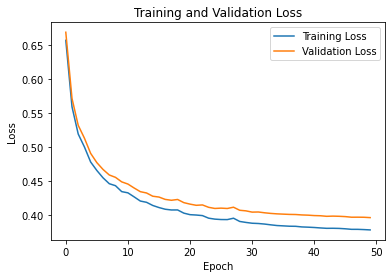

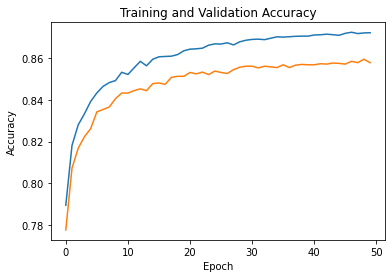

LR: 0.01, Hidden: 100, Lambda: 0.001, Best Val Acc: 0.8593333333333333
Epoch 1/50, Train Loss: 0.6723, Validation Loss: 0.6851, Validation Accuracy: 0.7725
Epoch 2/50, Train Loss: 0.5893, Validation Loss: 0.6019, Validation Accuracy: 0.8040
Epoch 3/50, Train Loss: 0.5536, Validation Loss: 0.5659, Validation Accuracy: 0.8108
Epoch 4/50, Train Loss: 0.5316, Validation Loss: 0.5433, Validation Accuracy: 0.8195
Epoch 5/50, Train Loss: 0.5184, Validation Loss: 0.5293, Validation Accuracy: 0.8248
Epoch 6/50, Train Loss: 0.5110, Validation Loss: 0.5219, Validation Accuracy: 0.8285
Epoch 7/50, Train Loss: 0.5023, Validation Loss: 0.5131, Validation Accuracy: 0.8288
Epoch 8/50, Train Loss: 0.4979, Validation Loss: 0.5082, Validation Accuracy: 0.8310
Epoch 9/50, Train Loss: 0.4914, Validation Loss: 0.5020, Validation Accuracy: 0.8332
Epoch 10/50, Train Loss: 0.4922, Validation Loss: 0.5032, Validation Accuracy: 0.8325
Epoch 11/50, Train Loss: 0.4873, Validation Loss: 0.4988, Validation Accuracy:

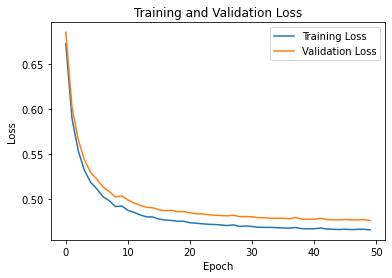

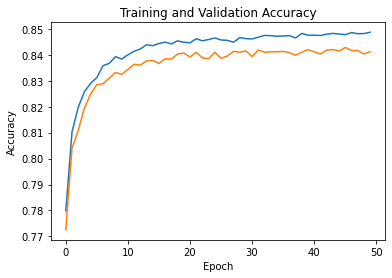

LR: 0.01, Hidden: 100, Lambda: 0.01, Best Val Acc: 0.8428333333333333
Epoch 1/50, Train Loss: 0.9178, Validation Loss: 0.9301, Validation Accuracy: 0.7182
Epoch 2/50, Train Loss: 0.9121, Validation Loss: 0.9234, Validation Accuracy: 0.7350
Epoch 3/50, Train Loss: 0.9063, Validation Loss: 0.9170, Validation Accuracy: 0.7410
Epoch 4/50, Train Loss: 0.9038, Validation Loss: 0.9130, Validation Accuracy: 0.7468
Epoch 5/50, Train Loss: 0.9018, Validation Loss: 0.9114, Validation Accuracy: 0.7455
Epoch 6/50, Train Loss: 0.8971, Validation Loss: 0.9056, Validation Accuracy: 0.7447
Epoch 7/50, Train Loss: 0.8953, Validation Loss: 0.9041, Validation Accuracy: 0.7385
Epoch 8/50, Train Loss: 0.8961, Validation Loss: 0.9051, Validation Accuracy: 0.7485
Epoch 9/50, Train Loss: 0.8915, Validation Loss: 0.8991, Validation Accuracy: 0.7435
Epoch 10/50, Train Loss: 0.8902, Validation Loss: 0.8976, Validation Accuracy: 0.7378
Epoch 11/50, Train Loss: 0.8912, Validation Loss: 0.8983, Validation Accuracy: 

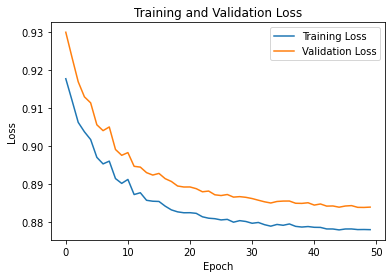

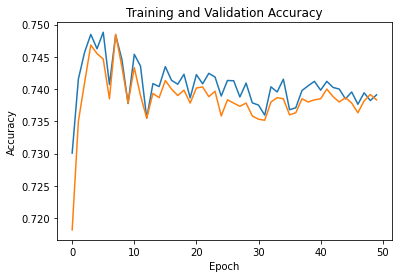

LR: 0.01, Hidden: 100, Lambda: 0.1, Best Val Acc: 0.7485
Epoch 1/50, Train Loss: 0.6441, Validation Loss: 0.6523, Validation Accuracy: 0.7887
Epoch 2/50, Train Loss: 0.5575, Validation Loss: 0.5687, Validation Accuracy: 0.8107
Epoch 3/50, Train Loss: 0.5179, Validation Loss: 0.5286, Validation Accuracy: 0.8203
Epoch 4/50, Train Loss: 0.4927, Validation Loss: 0.5034, Validation Accuracy: 0.8275
Epoch 5/50, Train Loss: 0.4755, Validation Loss: 0.4838, Validation Accuracy: 0.8308
Epoch 6/50, Train Loss: 0.4631, Validation Loss: 0.4728, Validation Accuracy: 0.8372
Epoch 7/50, Train Loss: 0.4491, Validation Loss: 0.4584, Validation Accuracy: 0.8410
Epoch 8/50, Train Loss: 0.4411, Validation Loss: 0.4508, Validation Accuracy: 0.8428
Epoch 9/50, Train Loss: 0.4385, Validation Loss: 0.4482, Validation Accuracy: 0.8447
Epoch 10/50, Train Loss: 0.4294, Validation Loss: 0.4397, Validation Accuracy: 0.8463
Epoch 11/50, Train Loss: 0.4274, Validation Loss: 0.4379, Validation Accuracy: 0.8487
Epoch 

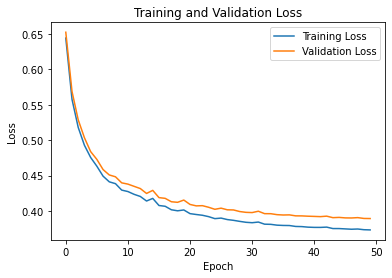

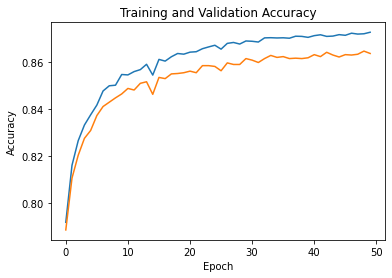

LR: 0.01, Hidden: 150, Lambda: 0.001, Best Val Acc: 0.8645
Epoch 1/50, Train Loss: 0.6596, Validation Loss: 0.6724, Validation Accuracy: 0.7820
Epoch 2/50, Train Loss: 0.5786, Validation Loss: 0.5912, Validation Accuracy: 0.8053
Epoch 3/50, Train Loss: 0.5488, Validation Loss: 0.5600, Validation Accuracy: 0.8110
Epoch 4/50, Train Loss: 0.5242, Validation Loss: 0.5366, Validation Accuracy: 0.8227
Epoch 5/50, Train Loss: 0.5134, Validation Loss: 0.5237, Validation Accuracy: 0.8262
Epoch 6/50, Train Loss: 0.5087, Validation Loss: 0.5189, Validation Accuracy: 0.8262
Epoch 7/50, Train Loss: 0.4968, Validation Loss: 0.5078, Validation Accuracy: 0.8322
Epoch 8/50, Train Loss: 0.4926, Validation Loss: 0.5036, Validation Accuracy: 0.8325
Epoch 9/50, Train Loss: 0.4890, Validation Loss: 0.4992, Validation Accuracy: 0.8323
Epoch 10/50, Train Loss: 0.4880, Validation Loss: 0.4982, Validation Accuracy: 0.8328
Epoch 11/50, Train Loss: 0.4847, Validation Loss: 0.4954, Validation Accuracy: 0.8365
Epoc

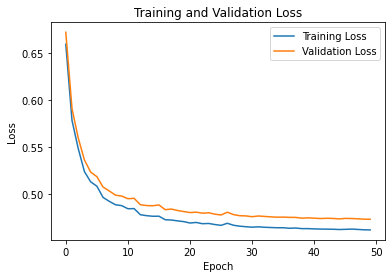

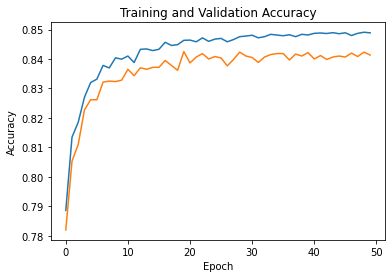

LR: 0.01, Hidden: 150, Lambda: 0.01, Best Val Acc: 0.8425
Epoch 1/50, Train Loss: 0.9134, Validation Loss: 0.9248, Validation Accuracy: 0.7250
Epoch 2/50, Train Loss: 0.9118, Validation Loss: 0.9240, Validation Accuracy: 0.7308
Epoch 3/50, Train Loss: 0.9077, Validation Loss: 0.9183, Validation Accuracy: 0.7312
Epoch 4/50, Train Loss: 0.9057, Validation Loss: 0.9152, Validation Accuracy: 0.7377
Epoch 5/50, Train Loss: 0.9019, Validation Loss: 0.9109, Validation Accuracy: 0.7377
Epoch 6/50, Train Loss: 0.8982, Validation Loss: 0.9077, Validation Accuracy: 0.7405
Epoch 7/50, Train Loss: 0.8961, Validation Loss: 0.9043, Validation Accuracy: 0.7477
Epoch 8/50, Train Loss: 0.8948, Validation Loss: 0.9033, Validation Accuracy: 0.7453
Epoch 9/50, Train Loss: 0.8925, Validation Loss: 0.9006, Validation Accuracy: 0.7420
Epoch 10/50, Train Loss: 0.8908, Validation Loss: 0.8985, Validation Accuracy: 0.7370
Epoch 11/50, Train Loss: 0.8889, Validation Loss: 0.8962, Validation Accuracy: 0.7415
Epoch

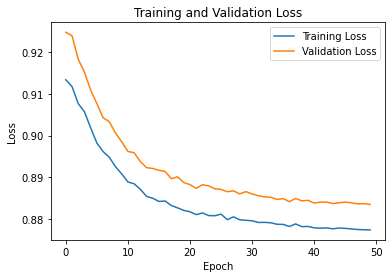

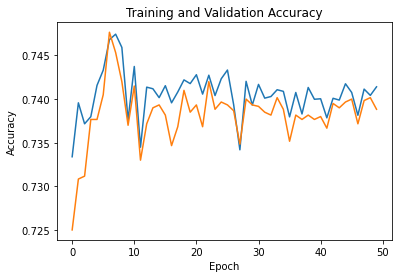

LR: 0.01, Hidden: 150, Lambda: 0.1, Best Val Acc: 0.7476666666666667
Epoch 1/50, Train Loss: 0.7991, Validation Loss: 0.8110, Validation Accuracy: 0.7245
Epoch 2/50, Train Loss: 0.6694, Validation Loss: 0.6807, Validation Accuracy: 0.7750
Epoch 3/50, Train Loss: 0.6061, Validation Loss: 0.6174, Validation Accuracy: 0.7972
Epoch 4/50, Train Loss: 0.5702, Validation Loss: 0.5822, Validation Accuracy: 0.8067
Epoch 5/50, Train Loss: 0.5453, Validation Loss: 0.5569, Validation Accuracy: 0.8120
Epoch 6/50, Train Loss: 0.5276, Validation Loss: 0.5388, Validation Accuracy: 0.8208
Epoch 7/50, Train Loss: 0.5135, Validation Loss: 0.5251, Validation Accuracy: 0.8212
Epoch 8/50, Train Loss: 0.5033, Validation Loss: 0.5146, Validation Accuracy: 0.8248
Epoch 9/50, Train Loss: 0.4953, Validation Loss: 0.5071, Validation Accuracy: 0.8262
Epoch 10/50, Train Loss: 0.4871, Validation Loss: 0.4985, Validation Accuracy: 0.8282
Epoch 11/50, Train Loss: 0.4829, Validation Loss: 0.4946, Validation Accuracy: 0

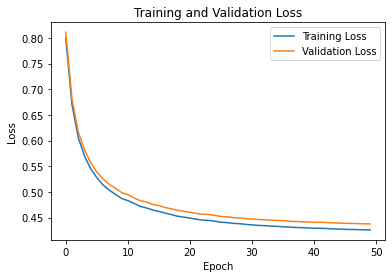

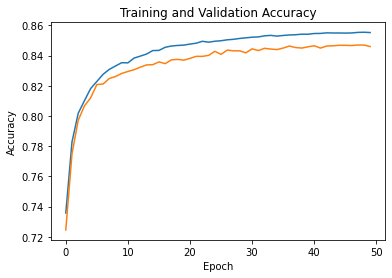

LR: 0.005, Hidden: 50, Lambda: 0.001, Best Val Acc: 0.847
Epoch 1/50, Train Loss: 0.7979, Validation Loss: 0.8135, Validation Accuracy: 0.7303
Epoch 2/50, Train Loss: 0.6700, Validation Loss: 0.6845, Validation Accuracy: 0.7718
Epoch 3/50, Train Loss: 0.6195, Validation Loss: 0.6347, Validation Accuracy: 0.7890
Epoch 4/50, Train Loss: 0.5855, Validation Loss: 0.5999, Validation Accuracy: 0.7995
Epoch 5/50, Train Loss: 0.5668, Validation Loss: 0.5816, Validation Accuracy: 0.8072
Epoch 6/50, Train Loss: 0.5510, Validation Loss: 0.5656, Validation Accuracy: 0.8137
Epoch 7/50, Train Loss: 0.5419, Validation Loss: 0.5570, Validation Accuracy: 0.8145
Epoch 8/50, Train Loss: 0.5318, Validation Loss: 0.5460, Validation Accuracy: 0.8222
Epoch 9/50, Train Loss: 0.5259, Validation Loss: 0.5401, Validation Accuracy: 0.8233
Epoch 10/50, Train Loss: 0.5201, Validation Loss: 0.5338, Validation Accuracy: 0.8250
Epoch 11/50, Train Loss: 0.5164, Validation Loss: 0.5301, Validation Accuracy: 0.8272
Epoch

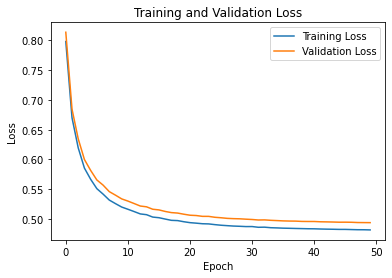

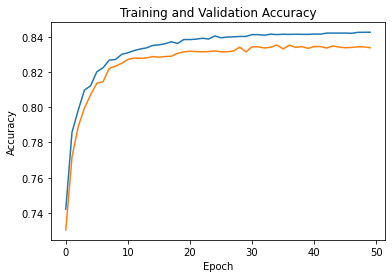

LR: 0.005, Hidden: 50, Lambda: 0.01, Best Val Acc: 0.8353333333333334
Epoch 1/50, Train Loss: 1.0040, Validation Loss: 1.0158, Validation Accuracy: 0.6808
Epoch 2/50, Train Loss: 0.9380, Validation Loss: 0.9498, Validation Accuracy: 0.7102
Epoch 3/50, Train Loss: 0.9238, Validation Loss: 0.9344, Validation Accuracy: 0.7185
Epoch 4/50, Train Loss: 0.9199, Validation Loss: 0.9301, Validation Accuracy: 0.7298
Epoch 5/50, Train Loss: 0.9174, Validation Loss: 0.9280, Validation Accuracy: 0.7277
Epoch 6/50, Train Loss: 0.9154, Validation Loss: 0.9245, Validation Accuracy: 0.7292
Epoch 7/50, Train Loss: 0.9123, Validation Loss: 0.9215, Validation Accuracy: 0.7353
Epoch 8/50, Train Loss: 0.9106, Validation Loss: 0.9204, Validation Accuracy: 0.7338
Epoch 9/50, Train Loss: 0.9090, Validation Loss: 0.9178, Validation Accuracy: 0.7385
Epoch 10/50, Train Loss: 0.9076, Validation Loss: 0.9162, Validation Accuracy: 0.7350
Epoch 11/50, Train Loss: 0.9060, Validation Loss: 0.9149, Validation Accuracy: 

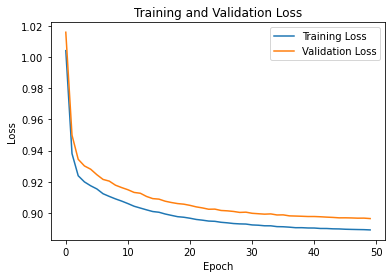

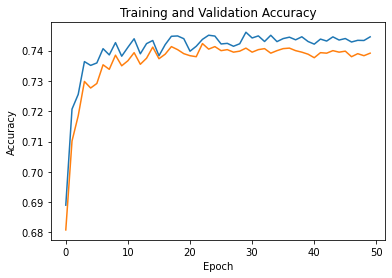

LR: 0.005, Hidden: 50, Lambda: 0.1, Best Val Acc: 0.7423333333333333
Epoch 1/50, Train Loss: 0.8010, Validation Loss: 0.8147, Validation Accuracy: 0.7232
Epoch 2/50, Train Loss: 0.6693, Validation Loss: 0.6837, Validation Accuracy: 0.7675
Epoch 3/50, Train Loss: 0.6088, Validation Loss: 0.6233, Validation Accuracy: 0.7907
Epoch 4/50, Train Loss: 0.5725, Validation Loss: 0.5870, Validation Accuracy: 0.8065
Epoch 5/50, Train Loss: 0.5502, Validation Loss: 0.5665, Validation Accuracy: 0.8100
Epoch 6/50, Train Loss: 0.5305, Validation Loss: 0.5462, Validation Accuracy: 0.8152
Epoch 7/50, Train Loss: 0.5162, Validation Loss: 0.5315, Validation Accuracy: 0.8202
Epoch 8/50, Train Loss: 0.5076, Validation Loss: 0.5232, Validation Accuracy: 0.8220
Epoch 9/50, Train Loss: 0.5012, Validation Loss: 0.5172, Validation Accuracy: 0.8198
Epoch 10/50, Train Loss: 0.4898, Validation Loss: 0.5048, Validation Accuracy: 0.8277
Epoch 11/50, Train Loss: 0.4833, Validation Loss: 0.4986, Validation Accuracy: 0

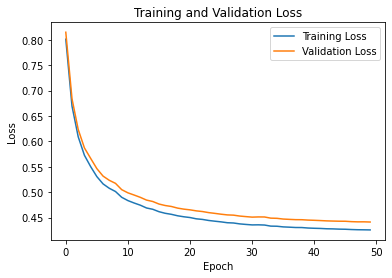

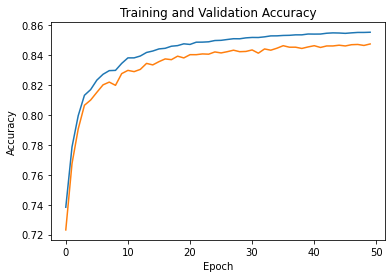

LR: 0.005, Hidden: 100, Lambda: 0.001, Best Val Acc: 0.8475
Epoch 1/50, Train Loss: 0.7985, Validation Loss: 0.8114, Validation Accuracy: 0.7410
Epoch 2/50, Train Loss: 0.6724, Validation Loss: 0.6858, Validation Accuracy: 0.7808
Epoch 3/50, Train Loss: 0.6180, Validation Loss: 0.6314, Validation Accuracy: 0.7950
Epoch 4/50, Train Loss: 0.5877, Validation Loss: 0.6004, Validation Accuracy: 0.8042
Epoch 5/50, Train Loss: 0.5668, Validation Loss: 0.5803, Validation Accuracy: 0.8092
Epoch 6/50, Train Loss: 0.5515, Validation Loss: 0.5650, Validation Accuracy: 0.8133
Epoch 7/50, Train Loss: 0.5403, Validation Loss: 0.5536, Validation Accuracy: 0.8172
Epoch 8/50, Train Loss: 0.5324, Validation Loss: 0.5459, Validation Accuracy: 0.8200
Epoch 9/50, Train Loss: 0.5252, Validation Loss: 0.5383, Validation Accuracy: 0.8228
Epoch 10/50, Train Loss: 0.5202, Validation Loss: 0.5335, Validation Accuracy: 0.8225
Epoch 11/50, Train Loss: 0.5160, Validation Loss: 0.5287, Validation Accuracy: 0.8258
Epo

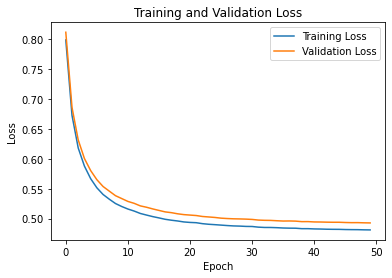

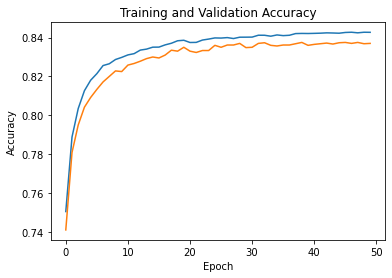

LR: 0.005, Hidden: 100, Lambda: 0.01, Best Val Acc: 0.8375
Epoch 1/50, Train Loss: 0.9852, Validation Loss: 0.9959, Validation Accuracy: 0.6960
Epoch 2/50, Train Loss: 0.9288, Validation Loss: 0.9398, Validation Accuracy: 0.7225
Epoch 3/50, Train Loss: 0.9174, Validation Loss: 0.9285, Validation Accuracy: 0.7290
Epoch 4/50, Train Loss: 0.9135, Validation Loss: 0.9241, Validation Accuracy: 0.7315
Epoch 5/50, Train Loss: 0.9123, Validation Loss: 0.9233, Validation Accuracy: 0.7338
Epoch 6/50, Train Loss: 0.9098, Validation Loss: 0.9199, Validation Accuracy: 0.7387
Epoch 7/50, Train Loss: 0.9078, Validation Loss: 0.9182, Validation Accuracy: 0.7368
Epoch 8/50, Train Loss: 0.9070, Validation Loss: 0.9166, Validation Accuracy: 0.7415
Epoch 9/50, Train Loss: 0.9049, Validation Loss: 0.9144, Validation Accuracy: 0.7393
Epoch 10/50, Train Loss: 0.9032, Validation Loss: 0.9124, Validation Accuracy: 0.7408
Epoch 11/50, Train Loss: 0.9026, Validation Loss: 0.9122, Validation Accuracy: 0.7407
Epoc

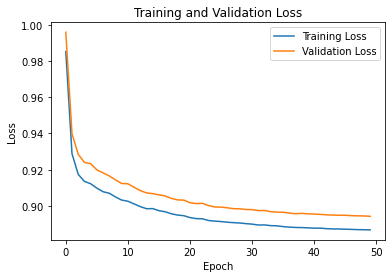

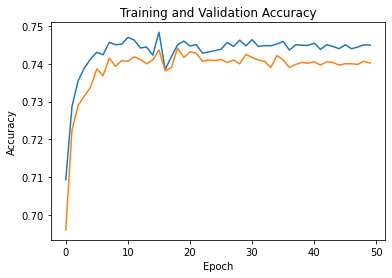

LR: 0.005, Hidden: 100, Lambda: 0.1, Best Val Acc: 0.7441666666666666
Epoch 1/50, Train Loss: 0.7961, Validation Loss: 0.8043, Validation Accuracy: 0.7307
Epoch 2/50, Train Loss: 0.6643, Validation Loss: 0.6742, Validation Accuracy: 0.7828
Epoch 3/50, Train Loss: 0.6019, Validation Loss: 0.6117, Validation Accuracy: 0.7968
Epoch 4/50, Train Loss: 0.5666, Validation Loss: 0.5783, Validation Accuracy: 0.8065
Epoch 5/50, Train Loss: 0.5425, Validation Loss: 0.5533, Validation Accuracy: 0.8132
Epoch 6/50, Train Loss: 0.5250, Validation Loss: 0.5353, Validation Accuracy: 0.8180
Epoch 7/50, Train Loss: 0.5122, Validation Loss: 0.5230, Validation Accuracy: 0.8223
Epoch 8/50, Train Loss: 0.5018, Validation Loss: 0.5123, Validation Accuracy: 0.8252
Epoch 9/50, Train Loss: 0.4947, Validation Loss: 0.5056, Validation Accuracy: 0.8282
Epoch 10/50, Train Loss: 0.4859, Validation Loss: 0.4964, Validation Accuracy: 0.8295
Epoch 11/50, Train Loss: 0.4797, Validation Loss: 0.4899, Validation Accuracy: 

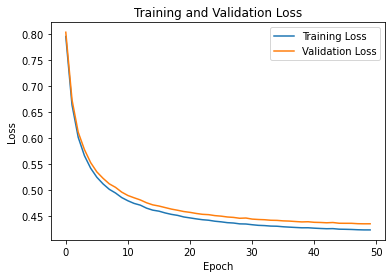

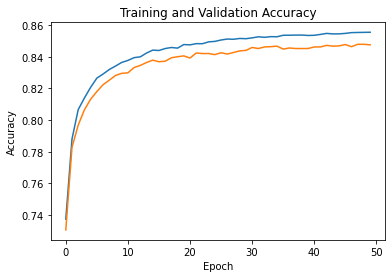

LR: 0.005, Hidden: 150, Lambda: 0.001, Best Val Acc: 0.8478333333333333
Epoch 1/50, Train Loss: 0.7970, Validation Loss: 0.8052, Validation Accuracy: 0.7350
Epoch 2/50, Train Loss: 0.6761, Validation Loss: 0.6848, Validation Accuracy: 0.7735
Epoch 3/50, Train Loss: 0.6212, Validation Loss: 0.6305, Validation Accuracy: 0.7910
Epoch 4/50, Train Loss: 0.5929, Validation Loss: 0.6026, Validation Accuracy: 0.8027
Epoch 5/50, Train Loss: 0.5697, Validation Loss: 0.5791, Validation Accuracy: 0.8113
Epoch 6/50, Train Loss: 0.5555, Validation Loss: 0.5652, Validation Accuracy: 0.8157
Epoch 7/50, Train Loss: 0.5436, Validation Loss: 0.5531, Validation Accuracy: 0.8213
Epoch 8/50, Train Loss: 0.5351, Validation Loss: 0.5454, Validation Accuracy: 0.8230
Epoch 9/50, Train Loss: 0.5267, Validation Loss: 0.5367, Validation Accuracy: 0.8243
Epoch 10/50, Train Loss: 0.5210, Validation Loss: 0.5308, Validation Accuracy: 0.8267
Epoch 11/50, Train Loss: 0.5161, Validation Loss: 0.5257, Validation Accuracy

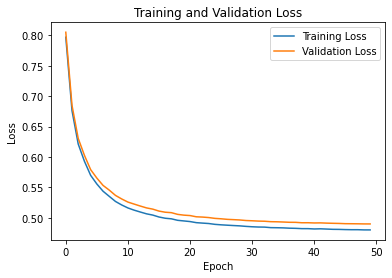

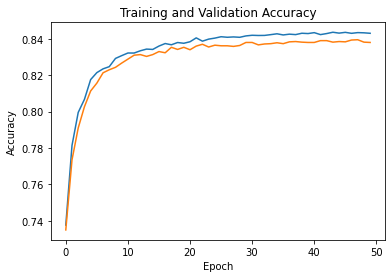

LR: 0.005, Hidden: 150, Lambda: 0.01, Best Val Acc: 0.8395
Epoch 1/50, Train Loss: 0.9595, Validation Loss: 0.9708, Validation Accuracy: 0.7070
Epoch 2/50, Train Loss: 0.9179, Validation Loss: 0.9300, Validation Accuracy: 0.7277
Epoch 3/50, Train Loss: 0.9121, Validation Loss: 0.9228, Validation Accuracy: 0.7387
Epoch 4/50, Train Loss: 0.9098, Validation Loss: 0.9205, Validation Accuracy: 0.7343
Epoch 5/50, Train Loss: 0.9094, Validation Loss: 0.9197, Validation Accuracy: 0.7323
Epoch 6/50, Train Loss: 0.9069, Validation Loss: 0.9177, Validation Accuracy: 0.7377
Epoch 7/50, Train Loss: 0.9053, Validation Loss: 0.9155, Validation Accuracy: 0.7380
Epoch 8/50, Train Loss: 0.9044, Validation Loss: 0.9142, Validation Accuracy: 0.7422
Epoch 9/50, Train Loss: 0.9028, Validation Loss: 0.9126, Validation Accuracy: 0.7337
Epoch 10/50, Train Loss: 0.9014, Validation Loss: 0.9107, Validation Accuracy: 0.7458
Epoch 11/50, Train Loss: 0.8997, Validation Loss: 0.9092, Validation Accuracy: 0.7425
Epoc

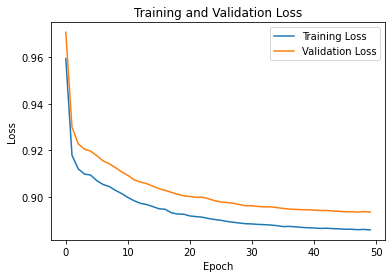

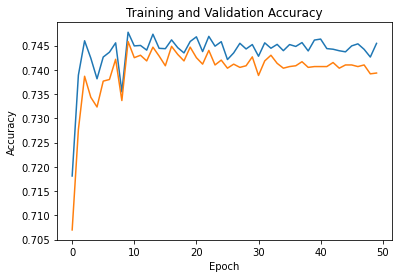

LR: 0.005, Hidden: 150, Lambda: 0.1, Best Val Acc: 0.7458333333333333
Epoch 1/50, Train Loss: 1.3534, Validation Loss: 1.3652, Validation Accuracy: 0.6218
Epoch 2/50, Train Loss: 1.0620, Validation Loss: 1.0764, Validation Accuracy: 0.6783
Epoch 3/50, Train Loss: 0.9287, Validation Loss: 0.9430, Validation Accuracy: 0.7108
Epoch 4/50, Train Loss: 0.8522, Validation Loss: 0.8664, Validation Accuracy: 0.7305
Epoch 5/50, Train Loss: 0.8011, Validation Loss: 0.8152, Validation Accuracy: 0.7408
Epoch 6/50, Train Loss: 0.7646, Validation Loss: 0.7786, Validation Accuracy: 0.7482
Epoch 7/50, Train Loss: 0.7366, Validation Loss: 0.7508, Validation Accuracy: 0.7567
Epoch 8/50, Train Loss: 0.7146, Validation Loss: 0.7289, Validation Accuracy: 0.7638
Epoch 9/50, Train Loss: 0.6969, Validation Loss: 0.7111, Validation Accuracy: 0.7688
Epoch 10/50, Train Loss: 0.6822, Validation Loss: 0.6963, Validation Accuracy: 0.7723
Epoch 11/50, Train Loss: 0.6698, Validation Loss: 0.6838, Validation Accuracy: 

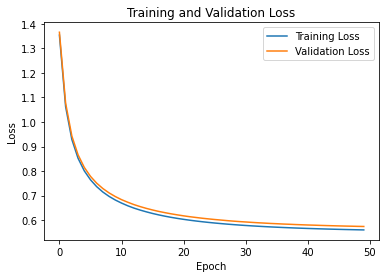

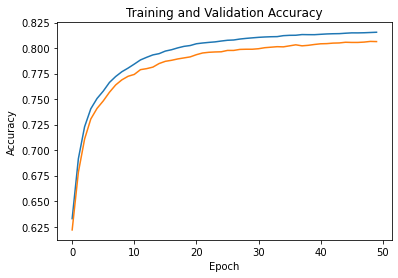

LR: 0.001, Hidden: 50, Lambda: 0.001, Best Val Acc: 0.8065
Epoch 1/50, Train Loss: 1.4542, Validation Loss: 1.4611, Validation Accuracy: 0.5965
Epoch 2/50, Train Loss: 1.1335, Validation Loss: 1.1447, Validation Accuracy: 0.6537
Epoch 3/50, Train Loss: 0.9783, Validation Loss: 0.9900, Validation Accuracy: 0.6792
Epoch 4/50, Train Loss: 0.8910, Validation Loss: 0.9027, Validation Accuracy: 0.7018
Epoch 5/50, Train Loss: 0.8363, Validation Loss: 0.8475, Validation Accuracy: 0.7182
Epoch 6/50, Train Loss: 0.7983, Validation Loss: 0.8093, Validation Accuracy: 0.7347
Epoch 7/50, Train Loss: 0.7697, Validation Loss: 0.7810, Validation Accuracy: 0.7417
Epoch 8/50, Train Loss: 0.7475, Validation Loss: 0.7584, Validation Accuracy: 0.7498
Epoch 9/50, Train Loss: 0.7295, Validation Loss: 0.7407, Validation Accuracy: 0.7553
Epoch 10/50, Train Loss: 0.7147, Validation Loss: 0.7258, Validation Accuracy: 0.7597
Epoch 11/50, Train Loss: 0.7023, Validation Loss: 0.7132, Validation Accuracy: 0.7627
Epoc

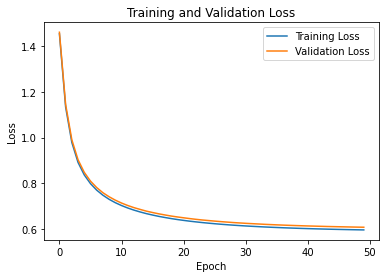

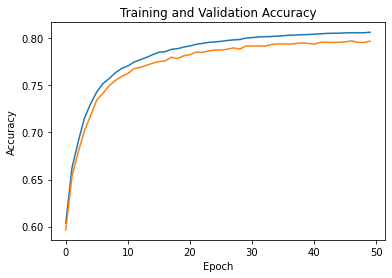

LR: 0.001, Hidden: 50, Lambda: 0.01, Best Val Acc: 0.7973333333333333
Epoch 1/50, Train Loss: 1.4325, Validation Loss: 1.4333, Validation Accuracy: 0.6027
Epoch 2/50, Train Loss: 1.1944, Validation Loss: 1.2004, Validation Accuracy: 0.6747
Epoch 3/50, Train Loss: 1.0885, Validation Loss: 1.0967, Validation Accuracy: 0.6813
Epoch 4/50, Train Loss: 1.0315, Validation Loss: 1.0407, Validation Accuracy: 0.6908
Epoch 5/50, Train Loss: 0.9969, Validation Loss: 1.0070, Validation Accuracy: 0.6975
Epoch 6/50, Train Loss: 0.9757, Validation Loss: 0.9857, Validation Accuracy: 0.7015
Epoch 7/50, Train Loss: 0.9616, Validation Loss: 0.9719, Validation Accuracy: 0.7015
Epoch 8/50, Train Loss: 0.9521, Validation Loss: 0.9626, Validation Accuracy: 0.7042
Epoch 9/50, Train Loss: 0.9455, Validation Loss: 0.9560, Validation Accuracy: 0.7060
Epoch 10/50, Train Loss: 0.9406, Validation Loss: 0.9511, Validation Accuracy: 0.7132
Epoch 11/50, Train Loss: 0.9368, Validation Loss: 0.9472, Validation Accuracy: 

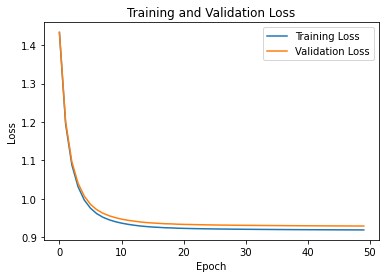

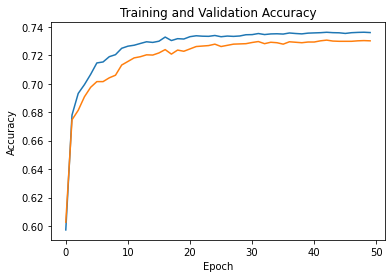

LR: 0.001, Hidden: 50, Lambda: 0.1, Best Val Acc: 0.7306666666666667
Epoch 1/50, Train Loss: 1.3023, Validation Loss: 1.3120, Validation Accuracy: 0.6495
Epoch 2/50, Train Loss: 1.0307, Validation Loss: 1.0440, Validation Accuracy: 0.6787
Epoch 3/50, Train Loss: 0.9095, Validation Loss: 0.9236, Validation Accuracy: 0.7025
Epoch 4/50, Train Loss: 0.8398, Validation Loss: 0.8544, Validation Accuracy: 0.7225
Epoch 5/50, Train Loss: 0.7935, Validation Loss: 0.8080, Validation Accuracy: 0.7332
Epoch 6/50, Train Loss: 0.7598, Validation Loss: 0.7745, Validation Accuracy: 0.7427
Epoch 7/50, Train Loss: 0.7342, Validation Loss: 0.7488, Validation Accuracy: 0.7505
Epoch 8/50, Train Loss: 0.7138, Validation Loss: 0.7284, Validation Accuracy: 0.7545
Epoch 9/50, Train Loss: 0.6971, Validation Loss: 0.7117, Validation Accuracy: 0.7588
Epoch 10/50, Train Loss: 0.6826, Validation Loss: 0.6973, Validation Accuracy: 0.7662
Epoch 11/50, Train Loss: 0.6706, Validation Loss: 0.6853, Validation Accuracy: 0

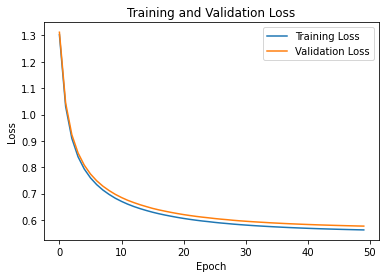

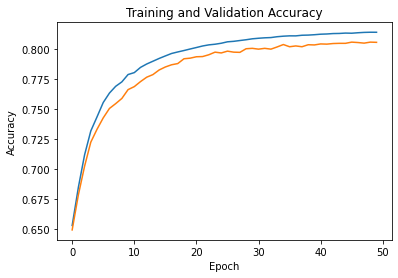

LR: 0.001, Hidden: 100, Lambda: 0.001, Best Val Acc: 0.8056666666666666
Epoch 1/50, Train Loss: 1.3304, Validation Loss: 1.3405, Validation Accuracy: 0.6253
Epoch 2/50, Train Loss: 1.0495, Validation Loss: 1.0618, Validation Accuracy: 0.6698
Epoch 3/50, Train Loss: 0.9276, Validation Loss: 0.9402, Validation Accuracy: 0.6982
Epoch 4/50, Train Loss: 0.8579, Validation Loss: 0.8700, Validation Accuracy: 0.7150
Epoch 5/50, Train Loss: 0.8113, Validation Loss: 0.8238, Validation Accuracy: 0.7293
Epoch 6/50, Train Loss: 0.7773, Validation Loss: 0.7898, Validation Accuracy: 0.7413
Epoch 7/50, Train Loss: 0.7513, Validation Loss: 0.7632, Validation Accuracy: 0.7505
Epoch 8/50, Train Loss: 0.7305, Validation Loss: 0.7422, Validation Accuracy: 0.7572
Epoch 9/50, Train Loss: 0.7134, Validation Loss: 0.7252, Validation Accuracy: 0.7657
Epoch 10/50, Train Loss: 0.6995, Validation Loss: 0.7113, Validation Accuracy: 0.7702
Epoch 11/50, Train Loss: 0.6874, Validation Loss: 0.6993, Validation Accuracy

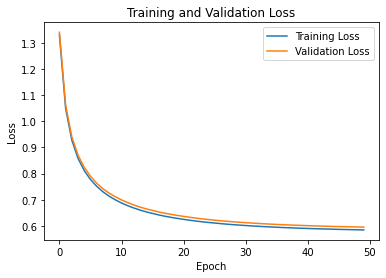

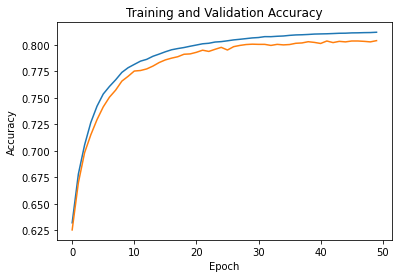

LR: 0.001, Hidden: 100, Lambda: 0.01, Best Val Acc: 0.8038333333333333
Epoch 1/50, Train Loss: 1.4188, Validation Loss: 1.4252, Validation Accuracy: 0.6342
Epoch 2/50, Train Loss: 1.1572, Validation Loss: 1.1660, Validation Accuracy: 0.6712
Epoch 3/50, Train Loss: 1.0493, Validation Loss: 1.0592, Validation Accuracy: 0.6835
Epoch 4/50, Train Loss: 0.9943, Validation Loss: 1.0048, Validation Accuracy: 0.6985
Epoch 5/50, Train Loss: 0.9632, Validation Loss: 0.9741, Validation Accuracy: 0.7048
Epoch 6/50, Train Loss: 0.9434, Validation Loss: 0.9546, Validation Accuracy: 0.7152
Epoch 7/50, Train Loss: 0.9313, Validation Loss: 0.9422, Validation Accuracy: 0.7163
Epoch 8/50, Train Loss: 0.9230, Validation Loss: 0.9338, Validation Accuracy: 0.7247
Epoch 9/50, Train Loss: 0.9174, Validation Loss: 0.9285, Validation Accuracy: 0.7270
Epoch 10/50, Train Loss: 0.9136, Validation Loss: 0.9247, Validation Accuracy: 0.7293
Epoch 11/50, Train Loss: 0.9111, Validation Loss: 0.9220, Validation Accuracy:

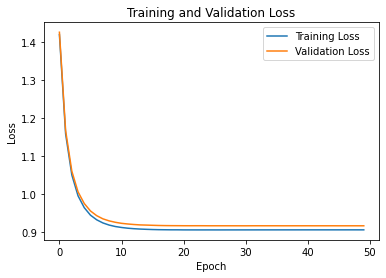

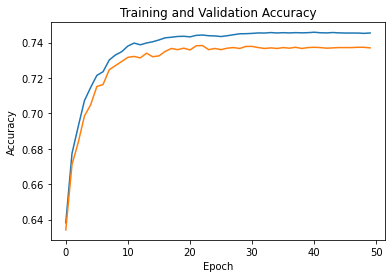

LR: 0.001, Hidden: 100, Lambda: 0.1, Best Val Acc: 0.7383333333333333
Epoch 1/50, Train Loss: 1.3107, Validation Loss: 1.3258, Validation Accuracy: 0.6228
Epoch 2/50, Train Loss: 1.0402, Validation Loss: 1.0560, Validation Accuracy: 0.6618
Epoch 3/50, Train Loss: 0.9193, Validation Loss: 0.9348, Validation Accuracy: 0.6872
Epoch 4/50, Train Loss: 0.8498, Validation Loss: 0.8646, Validation Accuracy: 0.7085
Epoch 5/50, Train Loss: 0.8035, Validation Loss: 0.8178, Validation Accuracy: 0.7232
Epoch 6/50, Train Loss: 0.7693, Validation Loss: 0.7831, Validation Accuracy: 0.7382
Epoch 7/50, Train Loss: 0.7429, Validation Loss: 0.7570, Validation Accuracy: 0.7485
Epoch 8/50, Train Loss: 0.7220, Validation Loss: 0.7358, Validation Accuracy: 0.7557
Epoch 9/50, Train Loss: 0.7040, Validation Loss: 0.7176, Validation Accuracy: 0.7602
Epoch 10/50, Train Loss: 0.6890, Validation Loss: 0.7028, Validation Accuracy: 0.7670
Epoch 11/50, Train Loss: 0.6764, Validation Loss: 0.6900, Validation Accuracy: 

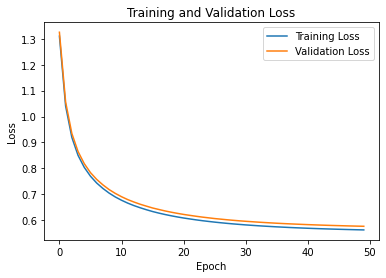

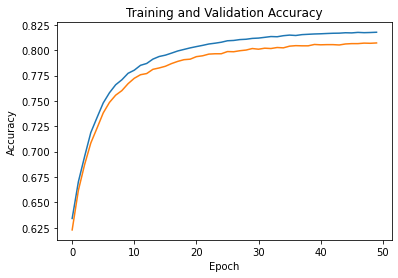

LR: 0.001, Hidden: 150, Lambda: 0.001, Best Val Acc: 0.8071666666666667
Epoch 1/50, Train Loss: 1.2878, Validation Loss: 1.3004, Validation Accuracy: 0.6212
Epoch 2/50, Train Loss: 1.0326, Validation Loss: 1.0454, Validation Accuracy: 0.6705
Epoch 3/50, Train Loss: 0.9200, Validation Loss: 0.9318, Validation Accuracy: 0.7037
Epoch 4/50, Train Loss: 0.8543, Validation Loss: 0.8660, Validation Accuracy: 0.7225
Epoch 5/50, Train Loss: 0.8102, Validation Loss: 0.8212, Validation Accuracy: 0.7330
Epoch 6/50, Train Loss: 0.7779, Validation Loss: 0.7891, Validation Accuracy: 0.7443
Epoch 7/50, Train Loss: 0.7528, Validation Loss: 0.7639, Validation Accuracy: 0.7487
Epoch 8/50, Train Loss: 0.7333, Validation Loss: 0.7443, Validation Accuracy: 0.7550
Epoch 9/50, Train Loss: 0.7163, Validation Loss: 0.7274, Validation Accuracy: 0.7608
Epoch 10/50, Train Loss: 0.7024, Validation Loss: 0.7135, Validation Accuracy: 0.7627
Epoch 11/50, Train Loss: 0.6904, Validation Loss: 0.7014, Validation Accuracy

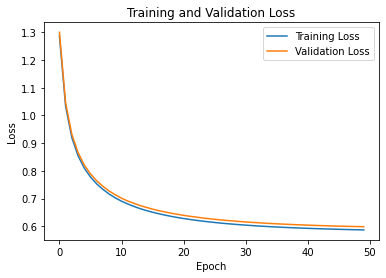

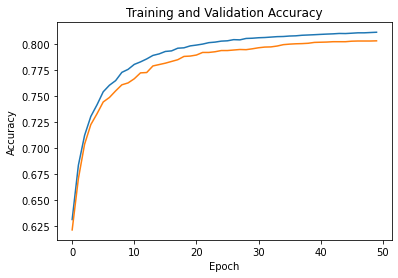

LR: 0.001, Hidden: 150, Lambda: 0.01, Best Val Acc: 0.8031666666666667
Epoch 1/50, Train Loss: 1.3848, Validation Loss: 1.3913, Validation Accuracy: 0.6308
Epoch 2/50, Train Loss: 1.1421, Validation Loss: 1.1514, Validation Accuracy: 0.6688
Epoch 3/50, Train Loss: 1.0415, Validation Loss: 1.0517, Validation Accuracy: 0.6863
Epoch 4/50, Train Loss: 0.9904, Validation Loss: 1.0004, Validation Accuracy: 0.6977
Epoch 5/50, Train Loss: 0.9603, Validation Loss: 0.9705, Validation Accuracy: 0.7060
Epoch 6/50, Train Loss: 0.9415, Validation Loss: 0.9517, Validation Accuracy: 0.7148
Epoch 7/50, Train Loss: 0.9292, Validation Loss: 0.9399, Validation Accuracy: 0.7177
Epoch 8/50, Train Loss: 0.9209, Validation Loss: 0.9314, Validation Accuracy: 0.7197
Epoch 9/50, Train Loss: 0.9154, Validation Loss: 0.9261, Validation Accuracy: 0.7238
Epoch 10/50, Train Loss: 0.9117, Validation Loss: 0.9224, Validation Accuracy: 0.7253
Epoch 11/50, Train Loss: 0.9093, Validation Loss: 0.9200, Validation Accuracy:

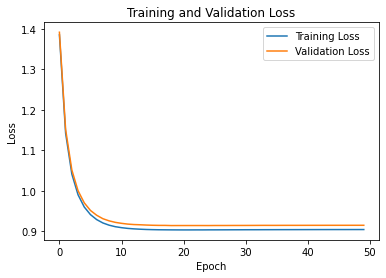

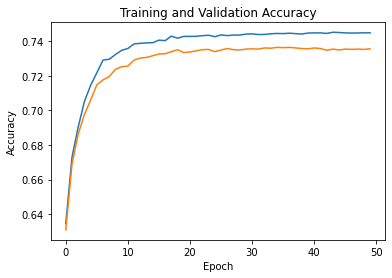

LR: 0.001, Hidden: 150, Lambda: 0.1, Best Val Acc: 0.7365


In [6]:
# 加载数据
def load_data():
    def load_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        return data.reshape(-1, 28*28) / 255.0

    def load_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    X_train = load_images('data/fashion-mnist/train-images-idx3-ubyte.gz')
    y_train = load_labels('data/fashion-mnist/train-labels-idx1-ubyte.gz')
    X_test = load_images('data/fashion-mnist/t10k-images-idx3-ubyte.gz')
    y_test = load_labels('data/fashion-mnist/t10k-labels-idx1-ubyte.gz')

    return X_train, X_test, y_train, y_test

# One-hot encode labels
def one_hot_encode(labels):
    encoder = OneHotEncoder(categories='auto')
    labels_one_hot = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
    return labels_one_hot

X_train, X_test, y_train, y_test = load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
y_train_one_hot = one_hot_encode(y_train)
y_val_one_hot = one_hot_encode(y_val)
y_test_one_hot = one_hot_encode(y_test)

input_size = 784  # 28*28
hidden_size = 128
output_size = 10

learning_rates = [0.01, 0.005, 0.001]
hidden_sizes = [50, 100, 150]
lambdas = [0.001, 0.01, 0.1]

epochs = 50
batch_size = 64

best_overall_val_acc = 0
best_overall_params = {}
best_lr = 0
best_hidden_size = 0
best_lambda_reg = 0

for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for lambda_reg in lambdas:
            model = NeuralNetwork(input_size, hidden_size, output_size)
            history = train(model, X_train, y_train_one_hot, X_val, y_val_one_hot, epochs, batch_size, lr, lambda_reg)
            plot_h(history)
            plt.close()
            current_val_acc = max(history['val_acc'])
            print(f"LR: {lr}, Hidden: {hidden_size}, Lambda: {lambda_reg}, Best Val Acc: {current_val_acc}")

            if current_val_acc > best_overall_val_acc:
                best_overall_val_acc = current_val_acc
                best_overall_params = model.params.copy()
                best_lr = lr
                best_hidden_size = hidden_size
                best_lambda_reg = lambda_reg


In [7]:
best_overall_params

{'W1': array([[ 0.01763143, -0.03001555,  0.03428093, ...,  0.05392933,
          0.00352652,  0.0568736 ],
        [ 0.07076138,  0.0077249 , -0.00430335, ..., -0.02370007,
         -0.04031043, -0.01762183],
        [ 0.03372078, -0.00210742, -0.03034941, ...,  0.02310432,
         -0.04616342, -0.03204228],
        ...,
        [ 0.03633119,  0.023002  ,  0.01278952, ..., -0.00451198,
         -0.01656759, -0.0329213 ],
        [ 0.0330121 ,  0.00661687,  0.00946913, ...,  0.08567753,
          0.02553531,  0.0406099 ],
        [-0.09623502, -0.01490731,  0.07392119, ...,  0.00364258,
         -0.01086856,  0.10756204]]),
 'b1': array([[ 0.0322235 , -0.00308999, -0.00500234,  0.25121845,  0.02004189,
          0.00332879,  0.09689051,  0.10669825, -0.01428571, -0.05544091,
          0.01451922,  0.02828964,  0.08687537, -0.0315456 ,  0.21214188,
          0.06965387, -0.14515196,  0.02645804, -0.07456639,  0.02798427,
         -0.01459524,  0.13850901,  0.0280195 , -0.04760112,  0.0

In [9]:
def test_model(model, X_test, y_test):
    test_output = model.forward(X_test)
    test_accuracy = np.mean(np.argmax(test_output, axis=1) == np.argmax(y_test, axis=1))
    print(f'Test Accuracy: {test_accuracy}')

In [10]:
model = NeuralNetwork(input_size, hidden_size, output_size)
model.params = best_overall_params
test_model(model, X_test, y_test_one_hot)

Test Accuracy: 0.8544


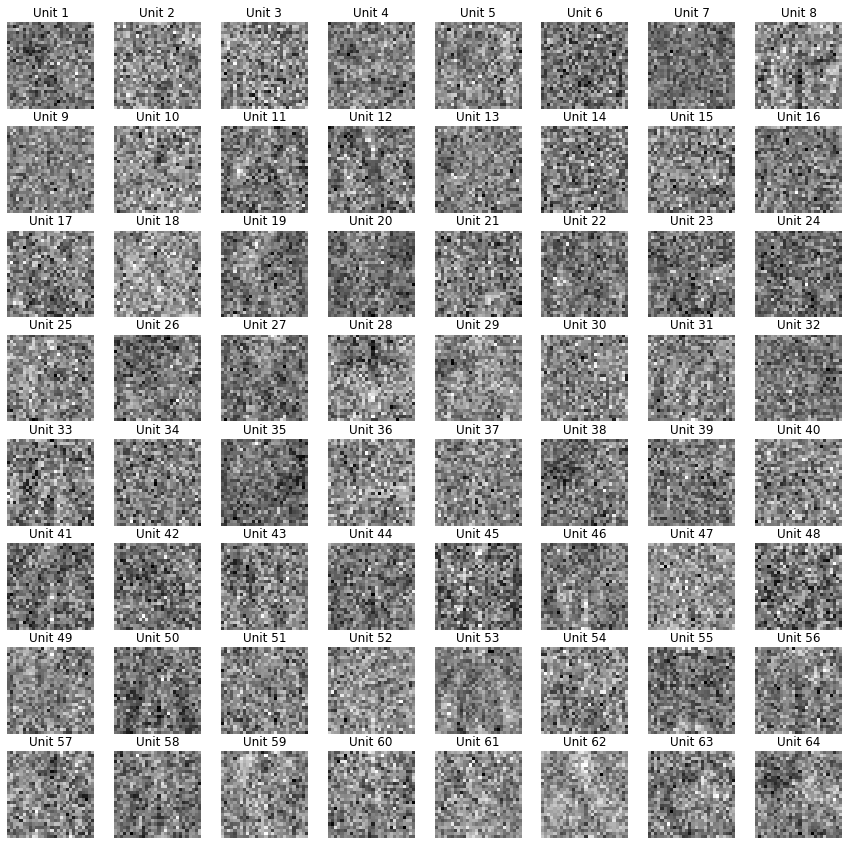

In [11]:
def visualize_weights(weights, figsize=(15, 15)):
    num_hidden_units = weights.shape[1]
    num_plots = min(num_hidden_units, 64)  # 最多可视化64个隐藏单元的权重
    num_cols = 8  # 列数
    num_rows = (num_plots + num_cols - 1) // num_cols  # 计算行数

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_plots):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_plots > 1 else axes
        ax.imshow(weights[:, i].reshape(28, 28), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Unit {i+1}')
    plt.show()

visualize_weights(model.params['W1'])


In [14]:
np.savetxt('W1.csv', model.params['W1'], delimiter=',')
np.savetxt('W2.csv', model.params['W2'], delimiter=',')
np.savetxt('b1.csv', model.params['b1'], delimiter=',')
np.savetxt('b2.csv', model.params['b2'], delimiter=',')